In [105]:
# Extract visible R and NIR bands
import rasterio
from rasterio.windows import Window
import numpy as np

image_file = "20210330_111622_19_106a_3B_AnalyticMS_SR.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(image_file) as src:
    band_red = src.read(3)

with rasterio.open(image_file) as src:
    band_nir = src.read(4)
    
# convert NoData to Nan    
#band_red[band_red == src.nodata] = np.nan
#band_nir[band_nir == src.nodata] = np.nan

In [106]:
# Converting the pixel values to TOA Reflectance
from xml.dom import minidom

xmldoc = minidom.parse("20210330_111622_19_106a_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

In [107]:
# Multiply the band values by the TOA Reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [108]:
# Calculate NDVI
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

# 1-99% contrast stretch
#vmin, vmax = np.nanpercentile(ndvi, (1,99))

# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(0.05554222751425419, 0.6817097715329241)

In [109]:
# Save NDVI image
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

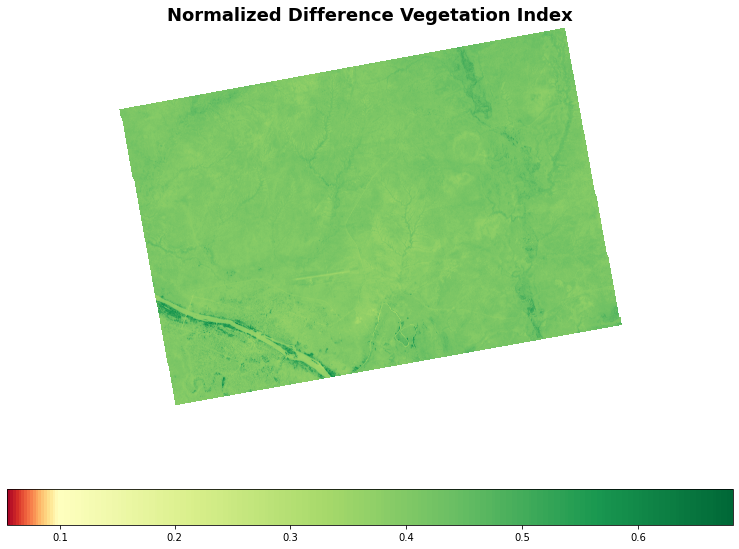

In [110]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

# fig.savefig("output/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

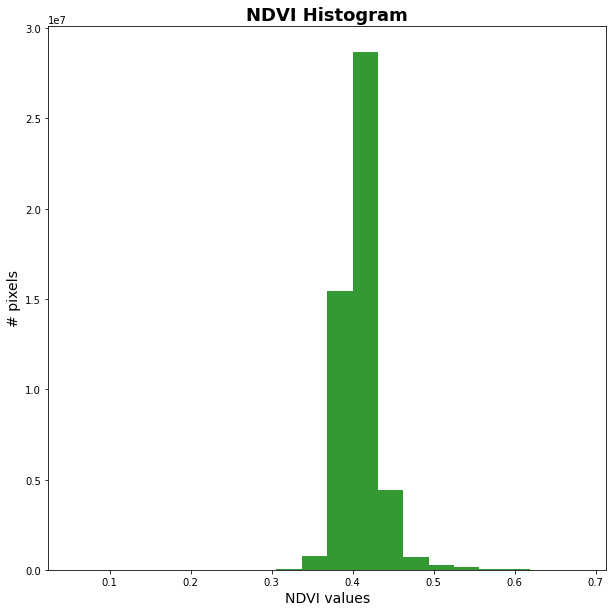

In [111]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

# fig2.savefig("output/ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()